In [ ]:
"""
Script to investigate why the down profiles result in lower SWHs than the up profiles...
"""

In [54]:


from scipy.io import loadmat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)

#Initialize arrays for storing stuff
big_spec_store = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
big_uncertainty_store = []
big_rotp_store = []
big_rotf_var_store = []
big_prof_speed_store = []
resid_store = np.array([])
big_min_bin_store = []
#For investigating down profiles
#down_min_z = []
#up_min_z =[]


up = True

float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
first_bot = []

##Testing for nans -- TO DO: Think we can delete this nan stuff
nancounter = 0
nanstorer = []
for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    spec_store = np.zeros((len(efr_files), 2 , 59))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    rotp_store = np.zeros(len(efr_files))
    rotf_var_store = np.zeros(len(efr_files))
    min_bin_store = np.zeros(len(efr_files))

    prof_speed_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 2))
    prof_store = np.empty(len(efr_files), dtype=object)
    
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)

        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #If up is true, flip everything
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
        else:
            #Do Nothing
            pass
            
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
        
        #Uncomment this to print out the filenames where EM starts before CTD
        #if len(moving_inds)<len(Pef):
            #print(len(Pef)-len(moving_inds), fname)
            #continue
            
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef_moving = Pef[moving_inds]
        
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1);
            e2off=np.nanmean(e2offs,1);
            e1fit=np.nanmean(e1fits,1);
            e2fit=np.nanmean(e2fits,1);
            resid = np.nanmean(resid,1);

        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit

        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        

        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)


        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

        E_x = E1_r
        E_y = E2_r
        
        #Now try highpass filtering the data
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        
        E_x = E_x_filtered
        E_y = E_y_filtered
        
    
        ##Get the mean residual level below 90m for the purpose of estimating error
        deep_inds = np.where(Pef_moving>=90)
        error = np.sqrt(np.square(e1r[deep_inds])+np.square(e2r[deep_inds]))
        resid_store = np.append(resid_store, error)
        
        
        #Now take the spectra
        nblock = 120
        fs = 1
        overlap = 60
        
        #in the case where the float doesn't actually move for nblock measurements, need to skip it
        if len(E_x)<nblock:
            #continue
            print(E_x)
            continue
        
      
                
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)

        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        
        #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
        #for each spectral window
        #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
        
        
        time_s = np.abs(mlt_efr - mlt_efr[0])
        rad_per_s = np.gradient(avg_angs, time_s) #radians per second. rotation period is 2pi/rad_per_s
        Rotp = 2*np.pi/rad_per_s
        
        [Rotp_reshaped, _] = reshape_u(Rotp, Pef, nblock, overlap, fs)
        
        window_rotp = np.nanmean(Rotp_reshaped, axis=1)
        
        prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])
        prof_speed_new = np.zeros(len(prof_speed))
        for block_ind in range(z_x.shape[0]):
            prof_speed_try = np.abs(np.gradient(z_x[block_ind, :], t_new[block_ind, :]))
            z_inds = prof_speed_try<0.001
            prof_speed_try[z_inds]=np.nan
            prof_speed_removed_zeros = np.nanmean(prof_speed_try)
            prof_speed_new[block_ind]=prof_speed_removed_zeros

        prof_speed = prof_speed_new
        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)


        
        #If the prof speed is really zero then we should maybe just filter out these measurements
        #This is generally the case bc the ctd data starts after the em data in some down profiles...
        nonzero_inds = np.where(np.isnan(prof_speed)==False)[0]
        if len(nonzero_inds)==0:#<len(prof_speed):
            #print(prof_speed)
         #   print(prof_speed_new)
            continue
        #print(len(nonzero_inds))
        #print(u_x.shape)
        u_x = u_x[nonzero_inds, :]    
        u_y = u_y[nonzero_inds, :]
        z_x = z_x[nonzero_inds, :]
        prof_speed = prof_speed[nonzero_inds]
        Rotp_reshaped = Rotp_reshaped[nonzero_inds, :]
        Rotf_reshaped = 1/Rotp_reshaped
        #Calculate Spectra
        UUwindow, fwindow = make_vel_spectrum(u_x, fs)

        VVwindow, fwindow = make_vel_spectrum(u_y, fs)
        

        min_z = np.min(z_x)
        #print(prof_num, min_z)
        #min_bin = np.append(min_bin, min_z)


        #Filter out profiles with min depths below 20m bc they don't have much signal...
        if min_z>20:
            #print(z_x)
            continue
        else:  
            first_bot = np.append(first_bot, z_x[0, -1])

            UU = UUwindow/(int(nblock/2)*fs)
            Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            VV = VVwindow/(int(nblock/2)*fs)
            Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

            Eh = Exx+Eyy
            
            if np.isnan(np.nanmean(np.nanmean(Eh, axis=0))):
                #print("All NaNs!!")
                if nancounter==0:
                    #plt.loglog(fwindow, np.transpose(VVwindow))
                    #plt.plot(np.transpose(u_y))
                    #plt.loglog(fwindow[1:], np.transpose(Eh))
                    print(make_vel_spectrum(u_y, fs))
                    
                temp1 = np.expand_dims(np.array(E_x), axis=0)
                temp2 = np.expand_dims(np.array(E_y), axis=0)
                temp3 = np.append(temp1, temp2, axis=0)
                nanstorer.append(temp3)
                #if nancounter<10:
                #    plt.figure()
                #    plt.plot(E_x)
                #    plt.plot(E_y)
                nancounter+=1
            [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            u_noise = 0 #This is just for testing...
            [lbound, ubound] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)
            
            #Average each profile spec and add to the storer
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                spec_store[counter, 0, :] = np.nanmean(Eh, axis=0)
                spec_store[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)
                
                time_store[counter] = np.nanmean(mlt_efr)
                prof_store[counter] = float_id+"_"+str(prof_num)
                min_bin_store[counter]=min_z
                uncertainty_store[counter, :] = np.array([lbound, ubound])
                rotp_store[counter]=np.nanmean(window_rotp)
                rotf_var_store[counter]=np.nanstd(1/window_rotp)
                prof_speed_store[counter]= np.nanmean(prof_speed)
                
                if np.nanmean(prof_speed)<0.06:
                    print("Prof speed ", prof_speed)
                    print("Prof speed new ", prof_speed_new)
                    print(z_x)
                
                if prof_num%2==0:
                    #Then it's even and its an up profile
                    up_down_store[counter] = 1
                else:
                    up_down_store[counter] = 0
                    #What do we want to save if it's a down?
                        #Min depth
                        #mean rotation frequency of the windows
                        #std of rotation frequency of the windows
                        

        
        
            counter+=1
        
        
    
    # Now store each one in a big array for sorting etc later
    if float_id_counter==0:
        big_spec_store=spec_store
        big_uncertainty_store = uncertainty_store
        big_time_store = time_store
        big_up_down_store = up_down_store
        big_prof_store = prof_store
        big_rotp_store = rotp_store
        big_prof_speed_store = prof_speed_store
        big_rotf_var_store = rotf_var_store
        big_min_bin_store = min_bin_store
    else:
        big_spec_store = np.append(big_spec_store, spec_store, axis=0)
        big_uncertainty_store = np.append(big_uncertainty_store,uncertainty_store, axis=0)
        big_time_store = np.append(big_time_store, time_store)
        big_up_down_store = np.append(big_up_down_store, up_down_store)
        big_prof_store = np.append(big_prof_store, prof_store)
        big_rotp_store = np.append(big_rotp_store, rotp_store)
        big_prof_speed_store = np.append(big_prof_speed_store, prof_speed_store)
        big_rotf_var_store = np.append(big_rotf_var_store, rotf_var_store)
        big_min_bin_store = np.append(big_min_bin_store, min_bin_store)






    
    float_id_counter+=1
        
    #np.save(save_dir+float_id, spec_store)



/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice


[ 0.04682711 -0.05316048 -0.02152868 -0.00228266 -0.00119699 -0.02278532
  0.00427321  0.05646292  0.12186944  0.03275289 -0.0952306  -0.1322489
 -0.05948848  0.0662074   0.11963114  0.06121783 -0.05311966 -0.10284827
 -0.08861857 -0.042603    0.03851785  0.08021213  0.06879104  0.01669531
  0.00281165  0.00838739  0.02596654  0.03696661  0.00432539 -0.03648124
 -0.06972437 -0.04079987 -0.00888935  0.02238726 -0.00978439 -0.01359914
  0.00228788 -0.01585719 -0.00436978  0.02200948  0.01042532 -0.01139432
 -0.02038049 -0.02339568  0.02404649  0.06223065  0.07258057  0.05855034
  0.03971476  0.00411824 -0.03288537 -0.05448169 -0.06687804 -0.09602299
 -0.10893197 -0.07698991 -0.01696672  0.06463716  0.13691832  0.1704419
  0.1087055   0.02324081 -0.06709489 -0.10547894 -0.07473866 -0.02541494
  0.02517809  0.04938974  0.00297728 -0.05107788 -0.0549971  -0.04512008
  0.01621019  0.0644065   0.05154515  0.02479009 -0.02581426 -0.05298063
 -0.02836523 -0.01073946  0.01140053  0.03440369  0.0

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)


[ 0.00710715 -0.01114732 -0.0130085   0.00346598  0.0184218   0.01874722
  0.00634474 -0.01785012 -0.02169995  0.00474046  0.0055633  -0.00321961
 -0.01206397 -0.01015173 -0.01078504 -0.01493163  0.00830672  0.02792359
  0.04493091  0.04111179  0.02497987 -0.01109294 -0.01626959 -0.03775582
 -0.02504555 -0.03943952 -0.03831318 -0.0341215  -0.00375709  0.01953277
  0.03587174  0.02167985  0.02754097  0.03212933  0.02809413  0.02724368
  0.01975898  0.0012751  -0.02053511 -0.04023002 -0.03909489 -0.03508955
 -0.02912885 -0.01675478  0.00149674  0.02749826  0.01707865  0.02371671
  0.0158835   0.00584649  0.01348947 -0.02484675 -0.0319401  -0.00325853
  0.02841671  0.02753541  0.01606137 -0.00745905 -0.02461527 -0.02233061
 -0.0015175   0.02062054  0.0237632   0.00630735 -0.00507581 -0.02726318
 -0.02296684 -0.01350503  0.00815803  0.01146452  0.02547958  0.01092143
  0.00040694  0.00383874 -0.00616126         nan         nan         nan
         nan         nan]


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/3060883303.py:295: RuntimeWarning: Mean of empty slice


In [55]:
print(prof_speed_store)
print(rotp_store)
print(rotf_var_store)
print(prof_num)
print(np.nanmean(prof_speed))

[0.14858572 0.11841266 0.14954654 0.12054266 0.11816247 0.14634932
 0.1215868  0.14944468 0.14872386 0.12111798 0.12312962 0.14523103
 0.14261696 0.11941291 0.11994685 0.        ]
[ 9.47243169 14.629835    9.45717341 13.68896427 12.96804089 10.87610466
 12.23577357  9.41950357  9.58888502 13.24324524 12.9594421   9.6704534
  9.6171187  13.40461972 13.14193648  0.        ]
[0.00772937 0.00250501 0.00732975 0.00236603 0.00567065 0.01032173
 0.00331119 0.00629597 0.00590343 0.004455   0.00465682 0.00745435
 0.00599873 0.00433493 0.0042187  0.        ]
62
0.11994684810180534


In [56]:
#Cell for sorting the arrays by time

#Getting rid of the profiles where minimum depth was below 20m
kill = np.where(big_spec_store[:, 0, 5]==0)
print(len(kill[0]))

spec_store_shallow = np.delete(big_spec_store, kill[0], axis=0)
time_store_shallow = np.delete(big_time_store, kill[0], axis=0)
up_down_store_shallow = np.delete(big_up_down_store, kill[0], axis=0)
prof_store_shallow = np.delete(big_prof_store, kill[0], axis=0)
uncertainty_store_shallow = np.delete(big_uncertainty_store, kill[0], axis=0)
rotp_store_shallow = np.delete(big_rotp_store, kill[0], axis=0)
prof_speed_store_shallow = np.delete(big_prof_speed_store, kill[0], axis=0)
rotf_var_store_shallow = np.delete(big_rotf_var_store, kill[0], axis=0)
min_bin_store_shallow = np.delete(big_min_bin_store, kill[0], axis=0)
#Also load the netcdf data

fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = [datetime.datetime.fromtimestamp(t) for t in times]
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
#dtimes = datetime(time, 'convertfrom', 'posixtime');
nc.close()


print(big_spec_store.shape)
print(big_prof_store[3])
#

23
(174, 2, 59)
6667g_42


In [57]:
big_prof_store

array(['6667g_62', '6667g_2', '6667g_61', '6667g_42', '6667g_21',
       '6667g_41', '6667g_22', None, '6667i_21', '6667i_81', '6667i_42',
       '6667i_82', '6667i_22', '6667i_41', '6667i_62', '6667i_61',
       '6667i_2', None, '6675f_22', None, None, None, '6675i_2',
       '6675i_61', '6675i_62', '6675i_41', '6675i_82', '6675i_22',
       '6675i_42', '6675i_21', '6675i_81', None, '6675g_22', '6675g_41',
       '6675g_21', '6675g_42', '6675g_2', '6675g_62', None, None,
       '6674j_61', '6674j_2', '6674j_101', '6674j_62', '6674j_102',
       '6674j_82', '6674j_121', '6674j_22', '6674j_41', '6674j_142',
       '6674j_21', '6674j_122', '6674j_81', '6674j_141', '6674j_42', None,
       '6672h_101', '6672h_2', '6672h_61', '6672h_102', '6672h_62',
       '6672h_41', '6672h_22', '6672h_82', '6672h_121', '6672h_42',
       '6672h_122', '6672h_81', '6672h_21', None, '6674e_22', '6674e_82',
       '6674e_41', '6674e_81', '6674e_21', '6674e_42', '6674e_61',
       '6674e_2', '6674e_62', None

In [58]:
#Get pairs of profiles (corresponding up and downs)
prof_doub_arr = np.empty((len(prof_store_shallow),2), dtype="object")
for ind in range(len(prof_store_shallow)):
    sub_arr = prof_store_shallow[ind].split("_")
    sub_arr = np.array(sub_arr, dtype="str")
    prof_doub_arr[ind, :]= sub_arr
#print(prof_doub_arr)
#print(len(prof_doub_arr))




out = zip(spec_store_shallow, uncertainty_store_shallow, time_store_shallow, prof_doub_arr[:, 0], prof_doub_arr[:, 1], rotp_store_shallow, prof_speed_store_shallow, rotf_var_store_shallow)
#list(out)[0]
sorted_array = sorted(out, key=lambda tup: (tup[3], tup[4]))

out2 = zip(prof_doub_arr[:, 0], prof_doub_arr[:, 1], min_bin_store_shallow)
sorted_array2 = sorted(out2, key=lambda tup: (tup[0], tup[1]))

unzipped = ([ a for a,b,c,d,e,f,g,h in sorted_array ], [ b for a,b,c,d,e,f,g,h in sorted_array ], [c for a,b,c,d,e,f,g,h in sorted_array], [d for a,b,c,d,e,f,g,h in sorted_array], [e for a,b,c,d,e,f,g,h in sorted_array], [f for a,b,c,d,e,f,g,h in sorted_array], [g for a,b,c,d,e,f,g,h in sorted_array], [h for a,b,c,d,e,f,g,h in sorted_array])
unzipped2 = ([a for a,b,c in sorted_array2], [b for a,b,c in sorted_array2], [c for a,b,c in sorted_array2])

spec_store_sorted = np.array(unzipped[0])
uncertainty_store_sorted = np.array(unzipped[1])
time_store_sorted = np.array(unzipped[2])
floatid_store_sorted = np.array(unzipped[3])
prof_num_store_sorted = np.array(unzipped[4])
rotp_store_sorted = np.array(unzipped[5])
prof_speed_store_sorted = np.array(unzipped[6])
rotf_var_store_sorted = np.array(unzipped[7])

min_bin_store_sorted = np.array(unzipped2[2])
#Sort by first column
#prof_doub_arr = prof_doub_arr[np.lexsort((prof_doub_arr[:,1], prof_doub_arr[:, 0]))] 
#spec_store_shallow = spec_store_shallow[np.lexsort((prof_doub_arr[:,1], prof_doub_arr[:, 0])), :, :]
#time_store_shallow = time_store_shallow[np.lexsort((prof_doub_arr[:,1], prof_doub_arr[:, 0]))]

#Remove the "2" profiles bc they don't have corresponding "1" profiles...
#prof_doub_arr = prof_doub_arr[prof_doub_arr[:, 1]!='2']
#spec_store_shallow = time_store_shallow[prof_doub_arr[:, 1]!='2']
#time_store_shallow = time_store_shallow[prof_doub_arr[:, 1]!='2']


print(prof_num_store_sorted)
#remove prof==2
#
#kill2 = np.where(prof_num_store_sorted=='2')
#spec_store_sorted = np.delete(spec_store_sorted, kill2[0], axis=0)
#time_store_sorted = np.delete(time_store_sorted, kill2[0], axis=0)
#uncertainty_store_sorted = np.delete(uncertainty_store_sorted, kill2[0], axis=0)
#floatid_store_sorted = np.delete(floatid_store_sorted, kill2[0], axis=0)
#prof_num_store_sorted = np.delete(prof_num_store_sorted, kill2[0], axis=0)
#rotp_store_sorted = np.delete(rotp_store_sorted, kill2[0], axis=0)
#prof_speed_store_sorted = np.delete(prof_speed_store_sorted, kill2[0], axis=0)
#rotf_var_store_sorted = np.delete(rotf_var_store_sorted, kill2[0], axis=0)
#min_bin_store_sorted = np.delete(min_bin_store_sorted, kill2[0], axis=0)

#print(len(kill2[0]))
#Now plot in pairs
done_inds = []
pairs = []
for ind in range(len(prof_num_store_sorted)):
    if ind in done_inds:
        continue
    else:
        if floatid_store_sorted[ind]==floatid_store_sorted[ind+1]:
            if int(prof_num_store_sorted[ind])+1 == int(prof_num_store_sorted[ind+1]):
                #Ok now we've got a pair
                if len(pairs)==0:
                    pairs = np.array([[ind, ind+1]])
                else:
                    pairs = np.append(pairs, [[ind, ind+1]], axis=0)
                done_inds = done_inds+[ind, ind+1]


['2' '21' '22' '41' '42' '61' '62' '2' '21' '22' '41' '42' '61' '62' '81'
 '82' '101' '102' '121' '122' '141' '142' '2' '21' '22' '41' '42' '61'
 '62' '81' '82' '2' '22' '41' '42' '61' '62' '101' '102' '121' '122' '2'
 '21' '22' '41' '42' '61' '62' '81' '82' '2' '101' '102' '121' '122' '141'
 '142' '2' '21' '22' '41' '42' '61' '62' '81' '82' '2' '21' '22' '41' '42'
 '61' '62' '81' '82' '2' '21' '22' '41' '42' '101' '102' '121' '122' '141'
 '142' '2' '21' '22' '41' '42' '61' '62' '81' '82' '2' '22' '22' '2' '21'
 '22' '41' '42' '62' '2' '21' '22' '41' '42' '61' '62' '81' '82' '101'
 '102' '121' '122' '141' '142' '2' '21' '22' '41' '42' '61' '62' '81' '82'
 '2' '21' '22' '42' '61' '62' '81' '82' '101' '102' '121' '122' '141'
 '142' '2' '21' '22' '41' '42' '61' '62' '81' '82']


In [59]:
for pair in pairs:
    ind = pair[0]
    [p_f, p_spl] = get_peak_freq(fwindow[1:], spec_store_shallow[ind, 1, :])
    plt.figure()
    plt.subplot(121)
    plt.fill_between(fwindow[1:],spec_store_sorted[ind, 1, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted[ind, 1, :]*uncertainty_store_sorted[ind, 0],color='0.8')
    plt.loglog(fwindow[1:], spec_store_sorted[ind, 0, :], label="EM-APEX raw")
    plt.loglog(fwindow[1:], spec_store_sorted[ind, 1, :], label="EM-APEX corrected")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"Energy Density ($m^2$/Hz)")
    
    ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
    plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")

    plt.legend()
    if int(prof_num_store_sorted[ind])%2==0:
        plt.title(floatid_store_sorted[ind]+" "+prof_num_store_sorted[ind]+ " (up)")
    else:
        plt.title(floatid_store_sorted[ind]+" "+prof_num_store_sorted[ind]+ " (down)")



    plt.subplot(122)
    ind = pair[1]
    plt.fill_between(fwindow[1:],spec_store_sorted[ind, 1, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted[ind, 1, :]*uncertainty_store_sorted[ind, 0],color='0.8')
    plt.loglog(fwindow[1:], spec_store_sorted[ind, 0, :], label="EM-APEX raw")
    plt.loglog(fwindow[1:], spec_store_sorted[ind, 1, :], label="EM-APEX corrected")
    plt.xlabel("Frequency (Hz)")

    ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
    plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
    if int(prof_num_store_sorted[ind])%2==0:
        plt.title(floatid_store_sorted[ind]+" "+prof_num_store_sorted[ind]+ " (up)")
    else:
        plt.title(floatid_store_sorted[ind]+" "+prof_num_store_sorted[ind]+ " (down)")


    #plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/up_vs_down_spectra/"+floatid_store_sorted[pair[0]]+"_"+f'{int(prof_num_store_sorted[pair[0]]):03}'+".png", bbox_inches='tight')
    plt.close()



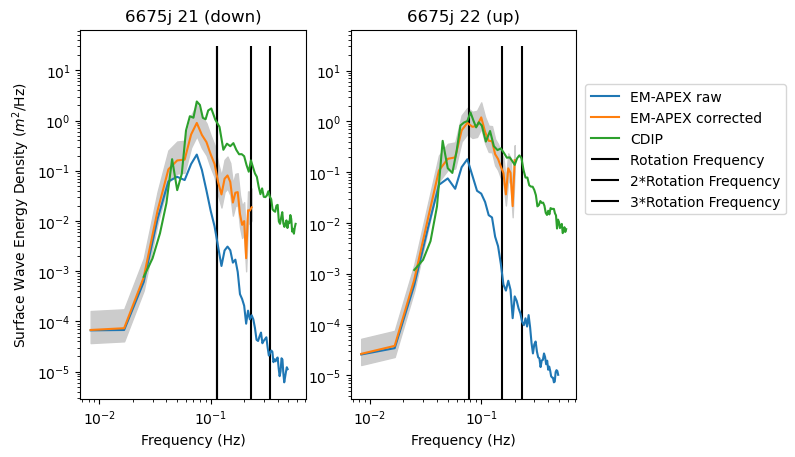

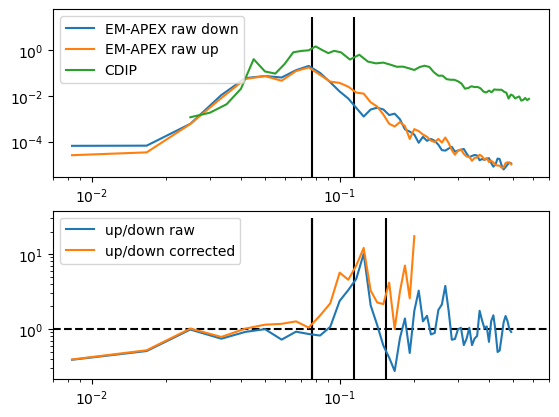

In [90]:
pair = pairs[51, :]
ind = pair[0]
[p_f, p_spl] = get_peak_freq(fwindow[1:], spec_store_shallow[ind, 1, :])
plt.figure()
plt.subplot(121)
plt.fill_between(fwindow[1:],spec_store_sorted[ind, 1, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted[ind, 1, :]*uncertainty_store_sorted[ind, 0],color='0.8')
plt.loglog(fwindow[1:], spec_store_sorted[ind, 0, :], label="EM-APEX raw")
plt.loglog(fwindow[1:], spec_store_sorted[ind, 1, :], label="EM-APEX corrected")
plt.vlines(x=1/rotp_store_sorted[ind], ymin=0, ymax=30, color='k')
plt.vlines(x=1/rotp_store_sorted[ind], ymin=0, ymax=30, color='k', label='Rotation Frequency')
plt.vlines(x=2/rotp_store_sorted[ind], ymin=0, ymax=30, color='k', label='Rotation Frequency')
plt.vlines(x=3/rotp_store_sorted[ind], ymin=0, ymax=30, color='k', label='Rotation Frequency')


plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Surface Wave Energy Density ($m^2$/Hz)")

ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")

if int(prof_num_store_sorted[ind])%2==0:
    plt.title(floatid_store_sorted[ind]+" "+prof_num_store_sorted[ind]+ " (up)")
else:
    plt.title(floatid_store_sorted[ind]+" "+prof_num_store_sorted[ind]+ " (down)")



plt.subplot(122)
ind = pair[1]
plt.fill_between(fwindow[1:],spec_store_sorted[ind, 1, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted[ind, 1, :]*uncertainty_store_sorted[ind, 0],color='0.8')
plt.loglog(fwindow[1:], spec_store_sorted[ind, 0, :], label="EM-APEX raw")
plt.loglog(fwindow[1:], spec_store_sorted[ind, 1, :], label="EM-APEX corrected")
plt.vlines(x=1/rotp_store_sorted[ind], ymin=0, ymax=30, color='k', label='Rotation Frequency')
plt.vlines(x=2/rotp_store_sorted[ind], ymin=0, ymax=30, color='k', label='2*Rotation Frequency')
plt.vlines(x=3/rotp_store_sorted[ind], ymin=0, ymax=30, color='k', label='3*Rotation Frequency')



plt.xlabel("Frequency (Hz)")

ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
if int(prof_num_store_sorted[ind])%2==0:
    plt.title(floatid_store_sorted[ind]+" "+prof_num_store_sorted[ind]+ " (up)")
else:
    plt.title(floatid_store_sorted[ind]+" "+prof_num_store_sorted[ind]+ " (down)")

plt.legend(loc=(1.04, 0.5))


plt.figure()
plt.subplot(211)
plt.loglog(fwindow[1:], spec_store_sorted[pair[0], 0, :], label="EM-APEX raw down")
plt.loglog(fwindow[1:], spec_store_sorted[pair[1], 0, :], label="EM-APEX raw up")
plt.vlines(x=1/rotp_store_sorted[pair[0]], ymin=0, ymax=30, color='k')
plt.vlines(x=1/rotp_store_sorted[pair[1]], ymin=0, ymax=30, color='k')


ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
plt.legend()
plt.xlim([0.007, 0.7])
plt.subplot(212)
plt.loglog(fwindow[1:], spec_store_sorted[pair[1], 0, :]/spec_store_sorted[pair[0], 0, :], label='up/down raw')
plt.loglog(fwindow[1:], spec_store_sorted[pair[1], 1, :]/spec_store_sorted[pair[0], 1, :], label='up/down corrected')


plt.legend()
plt.xlim([0.007, 0.7])
plt.vlines(x=1/rotp_store_sorted[pair[0]], ymin=0, ymax=30, color='k')
plt.vlines(x=1/rotp_store_sorted[pair[1]], ymin=0, ymax=30, color='k')
plt.vlines(x=1/rotp_store_sorted[ind], ymin=0, ymax=30, color='k', label='Rotation Frequency')
plt.vlines(x=2/rotp_store_sorted[pair[1]], ymin=0, ymax=30, color='k', label='Rotation Frequency')
#plt.vlines(x=3/rotp_store_sorted[ind], ymin=0, ymax=30, color='k', label='Rotation Frequency')


plt.hlines(y=1, xmin = 0.007, xmax=0.7, linestyles='--', color='k')

In [89]:
len(pairs)

65

In [49]:
#Can we get the difference at the rotation frequency for each spectrum between the real and measured spectral density?
diff_down = []
diff_up = []
for pair in pairs:
    #First downs
    ind = pair[0]
    rotf = 1/rotp_store_sorted[ind]
    
    #get closest frequency bin:
    rotf_ind = np.where(np.abs(fwindow[1:]-rotf)==np.min(np.abs(fwindow[1:]-rotf)))
    rotf_ind_cdip = np.where(np.abs(wave_freq-rotf)==np.min(np.abs(wave_freq-rotf)))
    
    ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))

    apex_spl = spec_store_sorted[ind, 1, rotf_ind]
    cdip_spl = energy_density[ind2[0][0], rotf_ind_cdip]
    diff_down = diff_down +[(cdip_spl-apex_spl)/cdip_spl]
    
    #now for ups
    ind = pair[1]
    rotf = 1/rotp_store_sorted[ind]
    
    #get closest frequency bin:
    rotf_ind = np.where(np.abs(fwindow[1:]-rotf)==np.min(np.abs(fwindow[1:]-rotf)))
    rotf_ind_cdip = np.where(np.abs(wave_freq-rotf)==np.min(np.abs(wave_freq-rotf)))
    
    ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))

    apex_spl = spec_store_sorted[ind, 1, rotf_ind]
    cdip_spl = energy_density[ind2[0][0], rotf_ind_cdip]
    diff_up = diff_down +[(cdip_spl-apex_spl)/cdip_spl]



In [50]:
# Are the rotation frequencies more consistent for the ups vs. downs?
# Where do the up and down profiles differ from the reference most?
cdip_diff_down = np.empty((pairs.shape[0], len(spec_store_sorted[0, 0, :])))
cdip_diff_up = np.empty((pairs.shape[0], len(spec_store_sorted[0, 0, :])))
cdip_diff_mean = np.empty((pairs.shape[0], len(spec_store_sorted[0, 0, :])))
rotf_up = np.empty(pairs.shape[0])
rotf_down = np.empty(pairs.shape[0])
speed_down = np.empty(pairs.shape[0])
speed_up = np.empty(pairs.shape[0])
rotf_var_up = np.empty(pairs.shape[0])
rotf_var_down = np.empty(pairs.shape[0])
min_bin_down = np.empty(pairs.shape[0])
min_bin_up = np.empty(pairs.shape[0])


counter = 0
for pair in pairs:
    #First downs
    dind = pair[0]
    rotf = 1/rotp_store_sorted[dind]
    
    #get closest frequency bin:
    rotf_ind = np.where(np.abs(fwindow[1:]-rotf)==np.min(np.abs(fwindow[1:]-rotf)))
    rotf_ind_cdip = np.where(np.abs(wave_freq-rotf)==np.min(np.abs(wave_freq-rotf)))
    
    ind2 = np.where(np.abs(time_store_sorted[dind]-times)==np.min(np.abs(time_store_sorted[dind]-times)))

    dcdip_dens_interp = np.interp(fwindow[1:], wave_freq, energy_density[ind2[0][0], :])
    
    cdip_diff_down[counter, :] = (dcdip_dens_interp - spec_store_sorted[dind, 1, :])
    rotf_down[counter] = 1/rotp_store_sorted[dind]
    rotf_var_down[counter]=rotf_var_store_sorted[dind]
    speed_down[counter] = prof_speed_store_sorted[dind]
    min_bin_down[counter]=min_bin_store_sorted[dind]
    
    uind = pair[1]
    rotf = 1/rotp_store_sorted[uind]
    
    #get closest frequency bin:
    rotf_ind = np.where(np.abs(fwindow[1:]-rotf)==np.min(np.abs(fwindow[1:]-rotf)))
    rotf_ind_cdip = np.where(np.abs(wave_freq-rotf)==np.min(np.abs(wave_freq-rotf)))
    
    ind2 = np.where(np.abs(time_store_sorted[uind]-times)==np.min(np.abs(time_store_sorted[uind]-times)))

    ucdip_dens_interp = np.interp(fwindow[1:], wave_freq, energy_density[ind2[0][0], :])
    rotf_up[counter] = 1/rotp_store_sorted[uind]
    cdip_diff_up[counter, :] = (ucdip_dens_interp - spec_store_sorted[uind, 1, :])
    speed_up[counter] = prof_speed_store_sorted[uind]
    rotf_var_up[counter]=rotf_var_store_sorted[uind]
    min_bin_up[counter]=min_bin_store_sorted[uind]


    
    
    #Now average them together:
    mean_spec = np.nanmean([[spec_store_sorted[dind, 1, :]], [spec_store_sorted[uind, 1, :]]], axis=0)
    mean_cdip = np.nanmean([[ucdip_dens_interp], [dcdip_dens_interp]], axis=0)
    cdip_diff_mean[counter, :] = (mean_cdip - mean_spec)
    
    counter+=1
    


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/2739663574.py:56: RuntimeWarning: Mean of empty slice
  mean_spec = np.nanmean([[spec_store_sorted[dind, 1, :]], [spec_store_sorted[uind, 1, :]]], axis=0)


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/2225646189.py:1: RuntimeWarning: Mean of empty slice
  avg_down = np.nanmean(cdip_diff_down, axis=0)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/2225646189.py:2: RuntimeWarning: Mean of empty slice
  avg_up = np.nanmean(cdip_diff_up, axis=0)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_11423/2225646189.py:5: RuntimeWarning: Mean of empty slice
  plt.plot(fwindow[1:], np.nanmean(cdip_diff_mean, axis=0))


(0.07, 0.25)

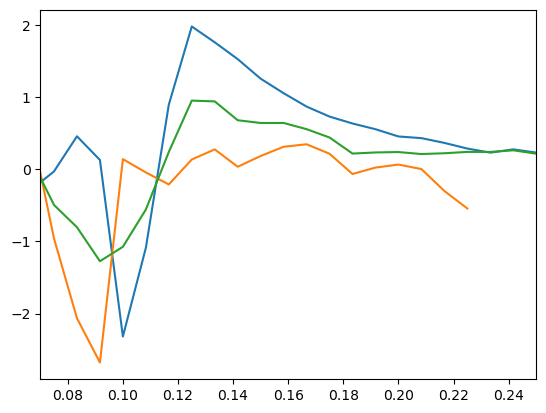

In [51]:
avg_down = np.nanmean(cdip_diff_down, axis=0)
avg_up = np.nanmean(cdip_diff_up, axis=0)
plt.plot(fwindow[1:], avg_down)
plt.plot(fwindow[1:], avg_up)
plt.plot(fwindow[1:], np.nanmean(cdip_diff_mean, axis=0))
plt.plot()
plt.xlim([0.07, 0.25])
#plt.ylim([-200, 100])
#plt.plot(fwindow[1:], np.transpose(np.nanmean([[avg_up], [avg_down]], axis=0)))
#plt.vlines(x=np.nanmedian(rotf_up), ymin=-3, ymax=2, color='orange')
#plt.vlines(x=np.nanmedian(rotf_down), ymin=-3, ymax=2, color='b')



Text(0.5, 1.0, 'Rotation Frequency vs. Profiling Speed for LCDRI experiment')

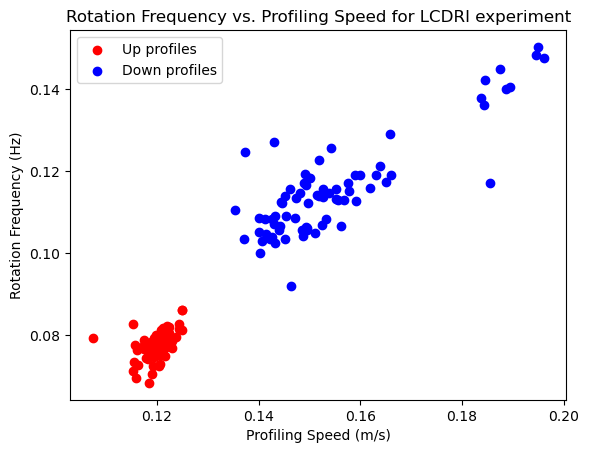

In [52]:
prof_speed_store_sorted.shape
rotp_store_sorted.shape

plt.scatter(speed_up, rotf_up, color='r', label='Up profiles')
plt.scatter(speed_down, rotf_down, color='b', label='Down profiles')
plt.legend()
plt.xlabel("Profiling Speed (m/s)")
plt.ylabel("Rotation Frequency (Hz)")
plt.title("Rotation Frequency vs. Profiling Speed for LCDRI experiment")

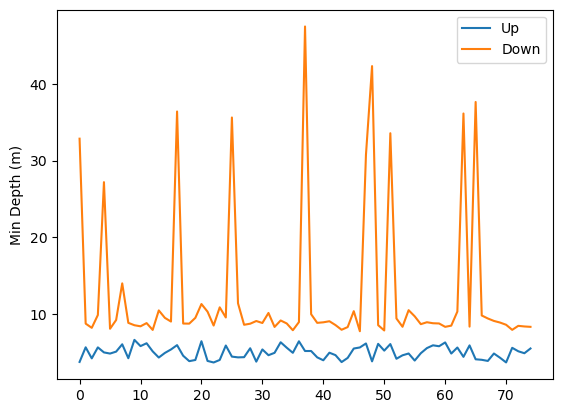

In [53]:
plt.plot(min_bin_up, label='Up')
plt.plot(min_bin_down, label='Down')
plt.ylabel("Min Depth (m)")
plt.legend()

In [52]:
np.nanmean(min_bin_down)

8.770042782738095

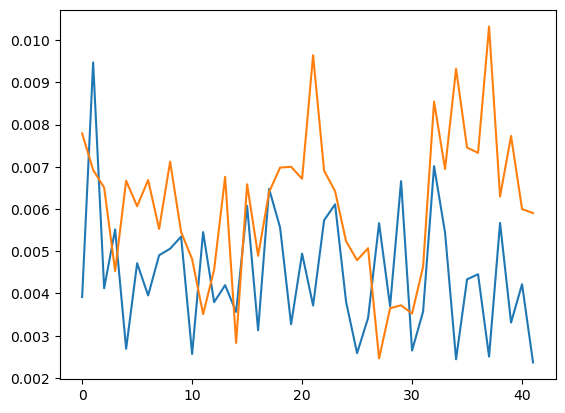

In [12]:
plt.plot(rotf_var_up)
plt.plot(rotf_var_down)

In [13]:
np.nanmean(rotf_var_down)

0.00610051065529031

In [14]:
np.nanmean(rotf_var_up)

0.004478316483830978

In [131]:
u_x.shape

(11, 120)